# Example mean field game system solution

In [63]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

power = 6
params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

def prepare_model(border_weight, colloc_weight, connect_weights):
    eps = 0.5

    sol = Solution(**params)

    w = 1
    k1 = connect_weights[0]
    k2 = connect_weights[1]
    # border_weight = 1
    # no_need_weight = 0

    itercoef=0.

    # colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
    #                                                                                             -(u_bas([0,1],0)*u_loc([0,1],1)+
    #                                                                                             u_loc([0,1],0)*u_bas([0,1],1)+

    #                                                                                             u_loc([0,0],0)*u_bas([0,2],1)+
    #                                                                                             u_bas([0,0],0)*u_loc([0,2],1))
    #                                                                                         ) * w**2*colloc_weight,

    #                         lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
    #                                                                                             +(u_bas([0,1],1)*u_loc([0,1],1))
    #                                                                                             ) * w**2*colloc_weight ,
    #                                                                                             ]


    # def popravka(f,g):
    #     return f*g
    # colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1))
    #                                                         ) * w**2*colloc_weight,
    #                         lambda u_loc, u_nei, x, x_loc: (popravka(u_loc([0,1],1),  u_loc([0,1],1))/2) * w**2*colloc_weight,
    #                         ]



    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                                -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                                
                                                                                                u_bas([0,0],0)*u_loc([0,2],1))
                                                                                            ) * w**2*colloc_weight,

                            lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                                +(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                                ) * w**2*colloc_weight ,
                                                                                                ]


    def popravka(f,g):
        return f*g
    colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (0) * w**2*colloc_weight,
                            lambda u_loc, u_nei, x, x_loc: (popravka(u_loc([0,1],1),  u_loc([0,1],1))/2) * w**2*colloc_weight,
                            ]

    
    colloc_ops = [colloc_left_operators, colloc_right_operators]


    def initial_state(x):
        t, x = x
        return x+1
        # sm_x = 3*x-1
        # if (x<2/3 and x>1/3):
        #     return 12 * (sm_x**2) *(1-sm_x)
        # else:
        #     return 0

    def terminal_state(x):
        t, x = x
        return -2*eps*np.log(x+1)
        # sm_x = 3*x-1
        # if (x<2/3 and x>1/3):
        #     return 12*sm_x*(1-sm_x)**2
        # else:
        #     return 0

    small = 1e-5

    def Bx(x):
        #border condition for x
        #check if t is greater than initial and lower than terminal
        # return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))
        return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

    def BtI(x):
        #border condition Initial for t
        return int(x[0]==sol.area_lims[0,0])

    def BtT(x):
        #border condtition Terminal for t
        return int(x[0]==sol.area_lims[0,1])

    border_left_operators = [
        lambda _, u_bas, x, x_loc: Bx(x)*(u_bas([0,0],1)) * border_weight,
        # lambda _, u_bas, x, x_loc: BtT(x)*(u_bas([0,0],0)-u_bas([0,0],1)) * border_weight, #* no_need_weight,
        lambda _, u_bas, x, x_loc: BtT(x)*(u_bas([0,0],1)) * border_weight, #* no_need_weight,
        
        # lambda _, u_bas, x, x_loc: BtI(x)*u_bas([0,0],0) * border_weight,

        lambda _, u_bas, x, x_loc: Bx(x)*u_bas([0,0],0) * border_weight,
        lambda _, u_bas, x, x_loc: BtI(x)*u_bas([0,0],0) * border_weight,
        # lambda _, u_bas, x, x_loc: BtT(x)*u_bas([0,0],0) * border_weight,
        ]

    border_right_operators = [
        lambda u, _, x, x_loc: Bx(x)* terminal_state(x) * border_weight, # border condition for psi
        # lambda u, _, x, x_loc: BtT(x) * (initial_state(x) - terminal_state(x)) * border_weight, #* no_need_weight,
        lambda u, _, x, x_loc: BtT(x) * (terminal_state(x)) * border_weight, #* no_need_weight,
        
        # lambda u, _, x, x_loc: BtI(x) * initial_state(x) * border_weight, # border and initial cond for s

        lambda u, _, x, x_loc: Bx(x)*initial_state(x) * border_weight,
        lambda u, _, x, x_loc: BtI(x)*initial_state(x) * border_weight,
        # lambda u, _, x, x_loc: BtT(x)*initial_state(x) * border_weight,
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = np.array([
                                [-1, 0.25], [-1, -0.25],
                                [-1, 0.75], [-1, -0.75],
                                
                                [0.25, -1], [0.25, -1],
                                [0.75, -1], [0.75, -1],
                                
                                [-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                [1, 1], [1, -1],
                                [-1, 1], [-1, -1],
                                ])

    
    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)


    for func_num in range(sol.n_funcs):
        # connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + np.sum(dir(x_loc)) * u_bas(dir(x_loc), func_num) * w,
                            # lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(2*dir(x_loc), func_num)* w**2 + np.sum(dir(x_loc)) * u_bas(3*dir(x_loc), func_num)* w**3
                            # ]
        # connect_right_operators += [lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc), func_num)* w,
                                    # lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(2*dir(x_loc), func_num)* w**2 - np.sum(dir(x_loc)) * u_nei(3*dir(x_loc), func_num)* w**3
                                    # ]
        connect_left_operators += [
                            # lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc), func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)* np.all(dir(x_loc)==[0,1]),
                            lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc), func_num) + k2*np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
                            # lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(2*dir(x_loc), func_num)* w**2 + np.sum(dir(x_loc)) * u_bas(3*dir(x_loc), func_num)* w**3
                            ]
        connect_right_operators += [
                                    # lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei([0,1],func_num)* np.all(dir(x_loc)==[0,-1]),
                                    lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
                                    # lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(2*dir(x_loc), func_num)* w**2 - np.sum(dir(x_loc)) * u_nei(3*dir(x_loc), func_num)* w**3
                                    ]

    
    
    # for func_num in range(sol.n_funcs):
    #     connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)*np.prod(dir(np.array([0.5,1]))==[0,1]))]
    #     connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)*np.prod(dir(np.array([0.5,1]))==[0,1]))]
    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [64]:
weights = {'border_weight':10,
'colloc_weight':1,
'connect_weights':[1,1]
}
sol, iteration_dict = prepare_model(**weights)
# A, b = sol.solve(solver = 'SVD', **iteration_dict, verbose=True)

In [61]:
A, b = sol.global_solve(solver = 'np', **iteration_dict, calculate = True, return_system=True, alpha = 0, verbose=True)

In [48]:
for i in range(2):
    sol.cell_division(i)

In [20]:
sol.cell_division(0)

In [65]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)



def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array


def plotter(x,y,data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X,Y,data)
    plt.show()

# for i in range(5):
new_eval=eval(sol)
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = eval(sol)
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.max(np.abs(prev_eval - new_eval)))
    # sol.plot2d()
    # plotter(ts, xs,np.transpose(np.abs(prev_eval - new_eval)))
    # plotter(ts, xs,np.transpose(prev_eval))
    # plotter(ts, xs,np.transpose(new_eval))


0  |  864661.3385089285  |  1894770.4985884842
1  |  864661.3415416649  |  1894770.5006708002
2  |  151986.99868579916  |  0.4467956248321789
3  |  32983.00599076622  |  0.6280030850883128
4  |  12781.890283607947  |  0.5715168659818364
5  |  1085.6390391736354  |  0.42520728625288917
6  |  463.8420019423481  |  0.4181334249204978
7  |  231.92094563646793  |  0.4975766805858317
8  |  115.96042076810836  |  0.3186526999695436
9  |  62.136537379308486  |  0.3277014908570506
10  |  44.29937710330666  |  1.2527580676445818
11  |  23.248617609481585  |  1.9496007218111169
12  |  40.06414673565968  |  3.0774767105647234
13  |  23.3917746243099  |  2.8323424908990296
14  |  23.48114066017805  |  9.452418145501035
15  |  24.441643575829723  |  9.982255887140314
16  |  22.471773376786498  |  5.968274719977359
17  |  31.684699891654166  |  15.390029916586585


KeyboardInterrupt: 

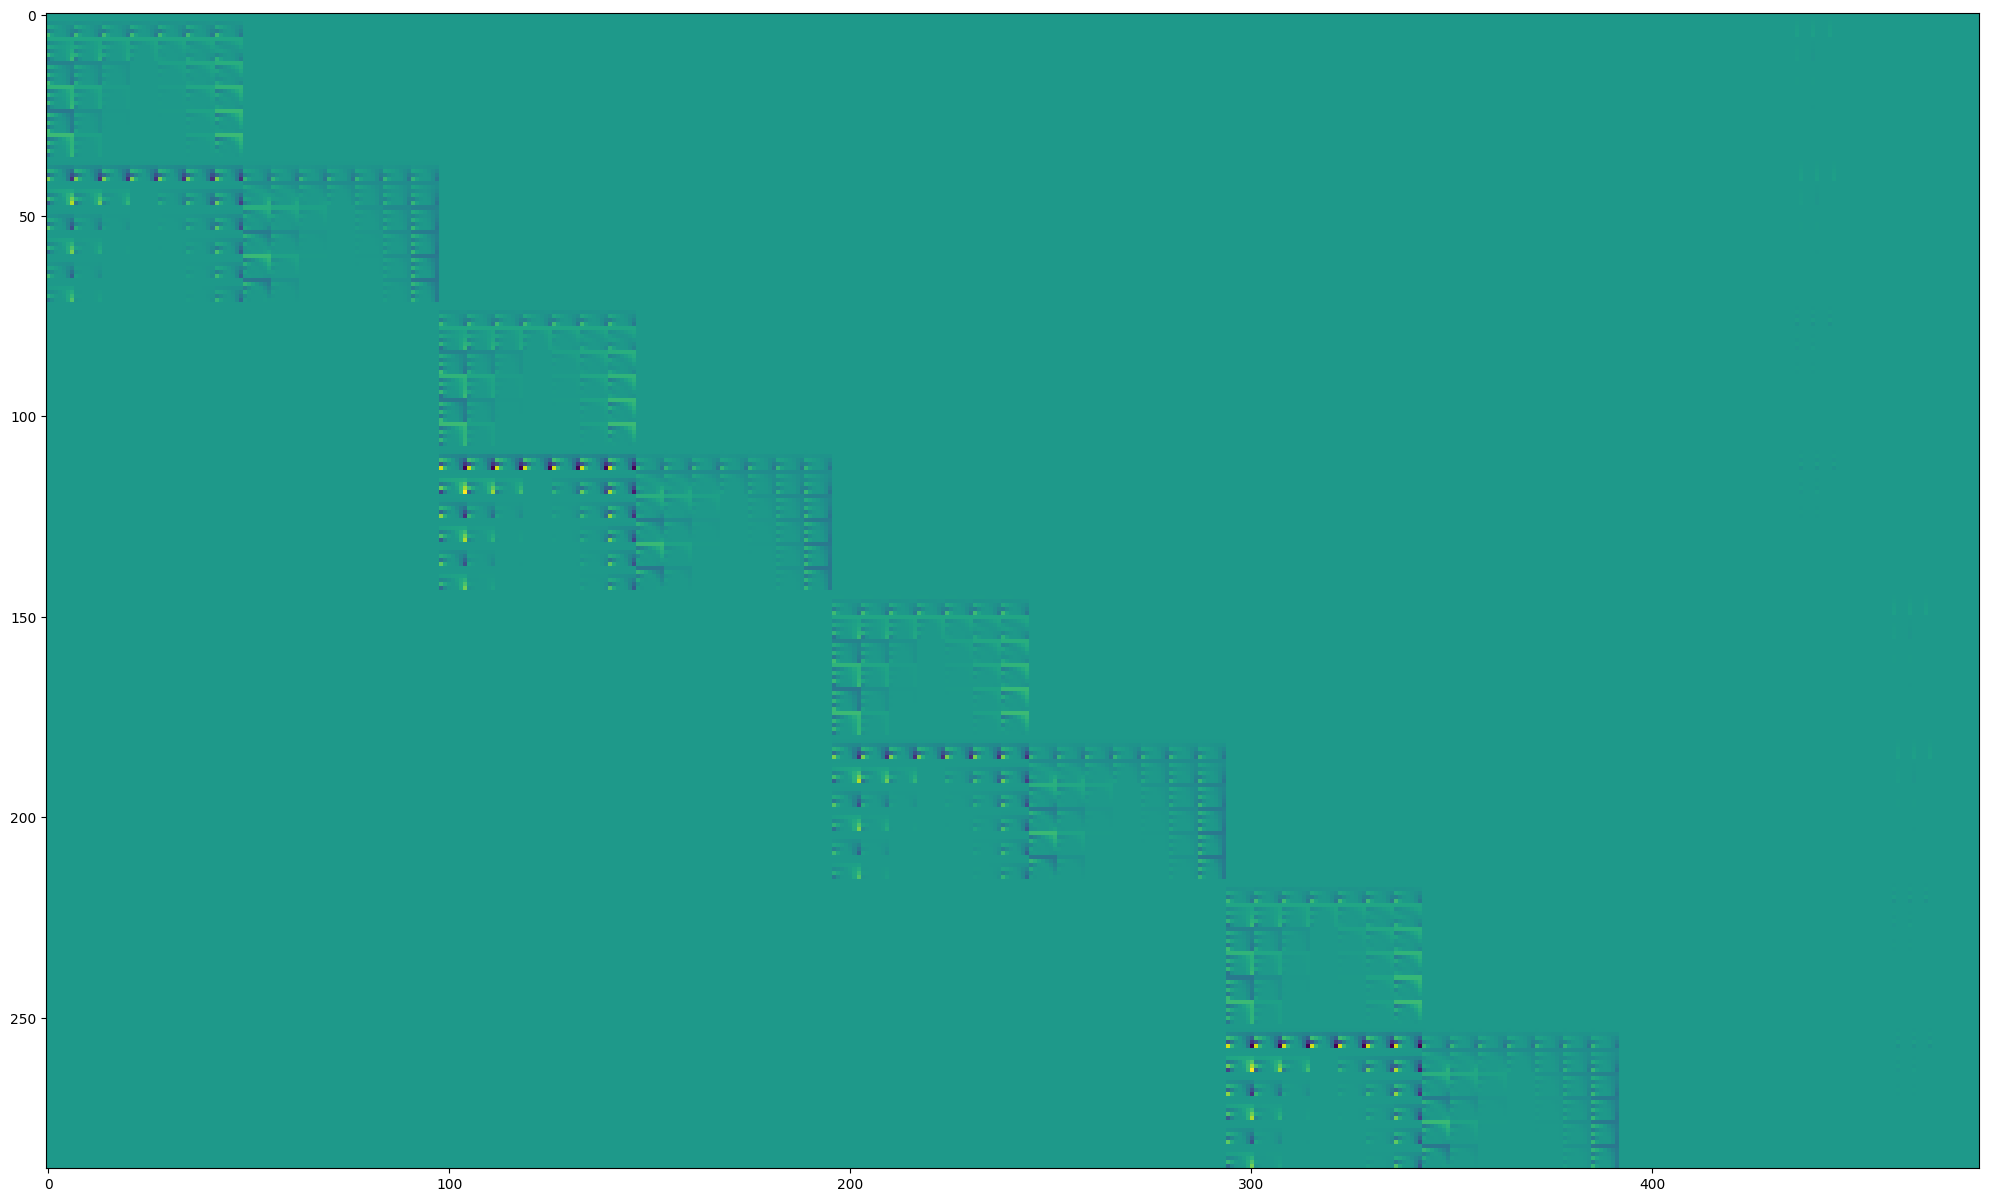

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
ax.imshow(A[:].T)
# ax.imshow(A[1152:1300,:100].T)

In [ ]:
A[1152:1160,:10]

array([], shape=(0, 10), dtype=float64)

In [ ]:
b[1152:1160]

array([-0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.   ,  1.375])

In [ ]:
sol.solve(solver='np',**iteration_dict)

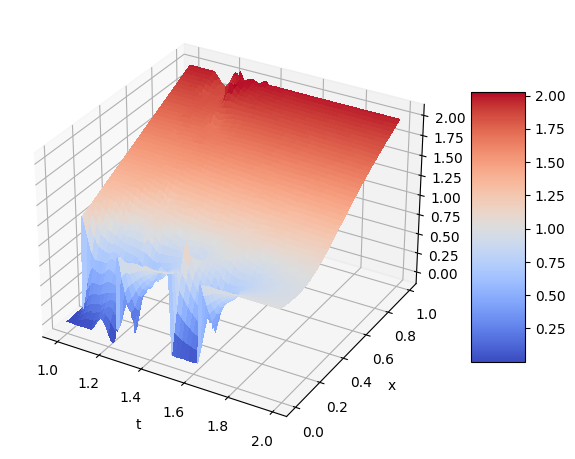

In [50]:
sol.plot2d(func_num=0)

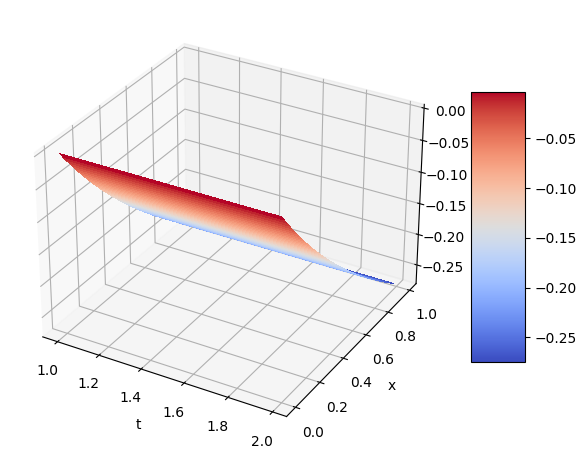

In [51]:
sol.plot2d(func_num=1)

## Weights experiments

In [ ]:
n=4
cweight_list = [2**i for i in range(n)]

bweight_list = [2**i for i in range(n)]

conditions = np.empty((n,n))

for bw, i in  zip(bweight_list, range(n)):
    for cw, j in zip(cweight_list, range(-2, n-2)):
        weights = {'border_weight':bw, 
        'colloc_weight':cw, 
        'connect_weights':[1,1]
        }
        sol, iteration_dict = prepare_model(**weights)
        A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
        conditions[i,j] = np.linalg.cond(A)

KeyboardInterrupt: 

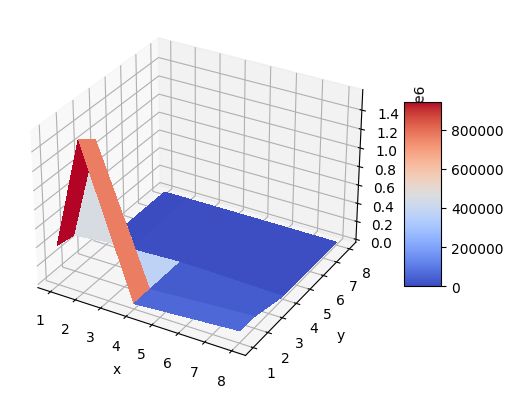

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
X, Y = np.meshgrid(bweight_list, cweight_list)
surf = ax.plot_surface(X,Y,  conditions, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [ ]:
weights = {'border_weight':200,
'colloc_weight':1.5,
'connect_weights':np.array([200,10]) * 0.75
}
sol, iteration_dict = prepare_model(**weights)
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
np.linalg.cond(A)

2063.431741718855

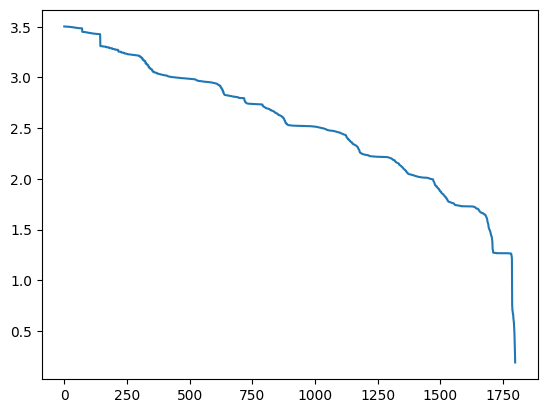

In [ ]:
_, s, __ = np.linalg.svd(A)
plt.plot(np.log(s)/np.log(10))

In [ ]:
#simple direct problem solving 

import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

a = 1
b = 1

eps = 0.01

power = 5
params = {
    'n_dims': 2,
    'dim_sizes': np.array([6, 6]),
    'area_lims': np.array([[0,0.1], [0,1]]),
    'power': power,
    'basis': Basis(power),
    'n_funcs': 2,
}
sol = Solution(**params)

w = 1
k1 = 1
k2 = 1
border_weight = 1
no_need_weight = 0


def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
                            
border_points = connect_points


colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                            -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                              u_loc([0,1],0)*u_bas([0,1],1)+

                                                                                             u_loc([0,0],0)*u_bas([0,2],1)+
                                                                                             u_bas([0,0],0)*u_loc([0,2],1))
                                                                                          ) * w**2,

                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                             +(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                            ) * w**2 ,
                                                                                            ]


def popravka(f,g):
    return f*g
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1))
                                                         ) * w**2,
                          lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,0],1),  u_loc([0,0],1))) * w**2,
                          ]
colloc_ops = [colloc_left_operators, colloc_right_operators]


def initial_state(x):
    t, x = x
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return 12 * (sm_x**2) *(1-sm_x)
    else:
        return 0

def terminal_state(x):
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return 12*sm_x*(1-sm_x)**2
    else:
        return 0

small = 1e-5


def Bx(x):
    #border condition for x
    #check if t is greater than initial and lower than terminal
    return int((x[0]>sol.area_lims[0,0]+small) and (x[0]<sol.area_lims[0,1]-small))

def BtI(x):
    #border condition Initial for t
    return int(x[0]<sol.area_lims[0,1]-small)

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]>sol.area_lims[0,1]-small)


border_left_operators = [
    # lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
    lambda _, u_bas, x, x_loc: (BtT(x)+Bx(x))*(u_bas([0,0],1)) * border_weight, #* no_need_weight,
    lambda _, u_bas, x, x_loc: (BtI(x))*u_bas([0,0],0) * border_weight,
    ]

border_right_operators = [
    # lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi
    lambda u, _, x, x_loc: (BtT(x)+Bx(x)) * (terminal_state(x[1])) * border_weight, #* no_need_weight,
    lambda u, _, x, x_loc: (BtI(x)) * initial_state(x) * border_weight, # border and initial cond for s
]

border_ops = [border_left_operators, border_right_operators]

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
points=[colloc_points, connect_points ,border_points]

connect_left_operators = []
connect_right_operators = []

def dir(point: np.array) -> np.array:
    direction = (np.abs(point) == 1) * (np.sign(point))
    return np.array(direction, dtype=int)
for func_num in range(sol.n_funcs):
    connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
    connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
connect_ops = [connect_left_operators, connect_right_operators]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
       'connect_ops':connect_ops
}

sol.cells_coefs *= 0.0



import copy
k=200
n=20
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)



def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array

r = np.array((k *sol.cells_coefs.shape))
# for i in range(5):
for j in range(k):
    prev_eval = eval(sol)
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', svd_threshold=1e-8, return_system=True, alpha = 0, **iteration_dict)
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.max(np.abs(prev_eval - eval(sol))))

0  |  1.604080865617538  |  1.6715580957935188
1  |  1.4470505985321283  |  0.09937222036605176
2  |  3.7111245129000285  |  3.783162675375419
3  |  1.1490887972391137  |  1.1400250410762485
4  |  2.675473885119291  |  2.0680406477614373
5  |  0.6493963331694023  |  0.2868938731268007
6  |  0.7985778045703024  |  0.7707462703601428
7  |  0.6864682603947216  |  0.7255323279386336
8  |  0.5469975475513826  |  0.46416199251825296
9  |  0.20412386408015348  |  0.14111682023766814
10  |  0.2797734926495421  |  0.21947275003155786
11  |  0.16675958343739272  |  0.1507374698179953
12  |  0.24039153261736135  |  0.279117532878183
13  |  0.2406636845033049  |  0.291961496950473
14  |  0.3270165529523267  |  0.35325270913548734
15  |  0.3694106349764994  |  0.4040504537783497
16  |  0.4531121402915559  |  0.4648645922471638
17  |  0.41210278812793943  |  0.4387348407322488
18  |  0.3182324026983655  |  0.33594056228846536
19  |  0.30411073511153675  |  0.3086580930831978
20  |  0.355308327201948

KeyboardInterrupt: 

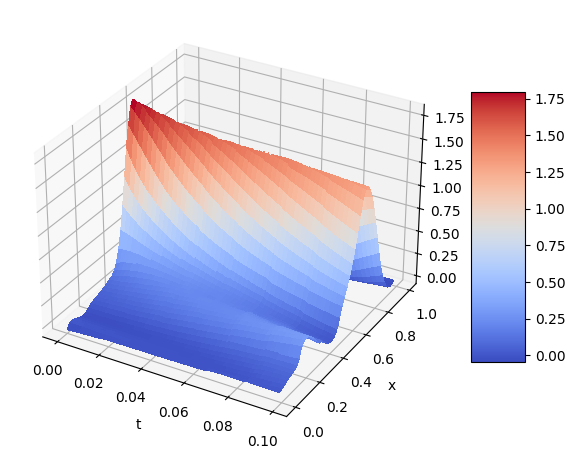

In [ ]:
sol.plot2d()

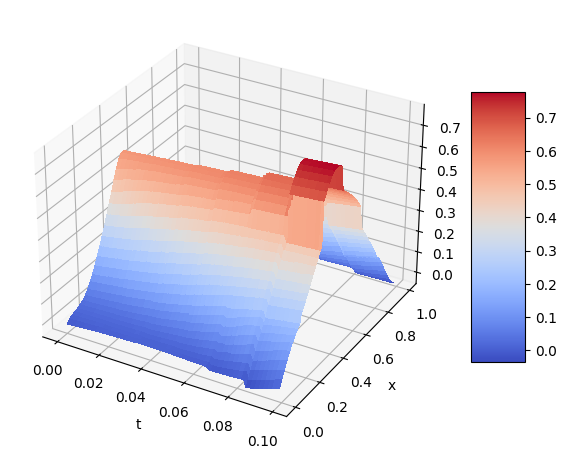

In [ ]:
sol.plot2d(func_num=1)

# Static case experiment

In [ ]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np


power = 5
params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0.1,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

def prepare_model(border_weight, colloc_weight, connect_weights):
    eps = 0.05

    sol = Solution(**params)

    w = 1
    k1 = connect_weights[0]
    k2 = connect_weights[1]
    # border_weight = 1
    # no_need_weight = 0

    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                                -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                                u_loc([0,1],0)*u_bas([0,1],1)+

                                                                                                u_loc([0,0],0)*u_bas([0,2],1)+
                                                                                                u_bas([0,0],0)*u_loc([0,2],1))
                                                                                            ) * w**2*colloc_weight,

                            lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                                +(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                                ) * w**2*colloc_weight ,
                                                                                                ]


    def popravka(f,g):
        return f*g
    colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1))
                                                            ) * w**2*colloc_weight,
                            lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,0],1),  u_loc([0,0],1))) * w**2*colloc_weight,
                            ]
    colloc_ops = [colloc_left_operators, colloc_right_operators]


    def initial_state(x):
        t, x = x
        sm_x = x
        return 6 * (sm_x) *(1-sm_x)
        
    def terminal_state(x):
        return -2*eps*np.log(x)

    small = 1e-5

    border_left_operators = [
        lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
        lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight, #* no_need_weight,
        lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*u_bas([0,0],0) * border_weight,
        ]

    border_right_operators = [
        lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi
        lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,0]+small) * (terminal_state(x[1])) * border_weight, #* no_need_weight,
        lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,0]+small) * initial_state(x) * border_weight, # border and initial cond for s
    ]

    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([[-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                [-1, 0], [1, 0],
                                [0, -1], [0, 1],
                                ])
    border_points = connect_points
    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)

    for func_num in range(sol.n_funcs):
        connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)*np.prod(dir(np.array([0.5,1]))==[0,1]))]
        connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: (k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)*np.prod(dir(np.array([0.5,1]))==[0,1]))]
    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [ ]:
weights = {'border_weight':10,
'colloc_weight':1, 
'connect_weights':[1,1]
}
sol, iteration_dict = prepare_model(**weights)
# A, b = sol.solve(solver = 'SVD', **iteration_dict, verbose=True)

In [ ]:
for i in range(2):
    sol.cell_division(i)

In [ ]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)



def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array


def plotter(x,y,data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X,Y,data)
    plt.show()

# for i in range(5):
new_eval=eval(sol)
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = eval(sol)
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.max(np.abs(prev_eval - new_eval)))
    # sol.plot2d()
    # plotter(ts, xs,np.transpose(np.abs(prev_eval - new_eval)))
    # plotter(ts, xs,np.transpose(prev_eval))
    # plotter(ts, xs,np.transpose(new_eval))


0  |  1.4788259915451492  |  1.5207346451532389
1  |  0.3510218996581165  |  0.21872810531402176
2  |  0.3169172925255651  |  0.35168401600088234
3  |  0.13566310517173835  |  0.11232745208966732
4  |  0.09239222127947483  |  0.06600838851215762
5  |  0.06614587629637353  |  0.07208803827636956
6  |  0.05746063123390277  |  0.04505799618571249
7  |  0.04447091655686797  |  0.04138470351450496
8  |  0.03746944856314827  |  0.031090179230155
9  |  0.0304321477596452  |  0.026619570869968356


KeyboardInterrupt: 

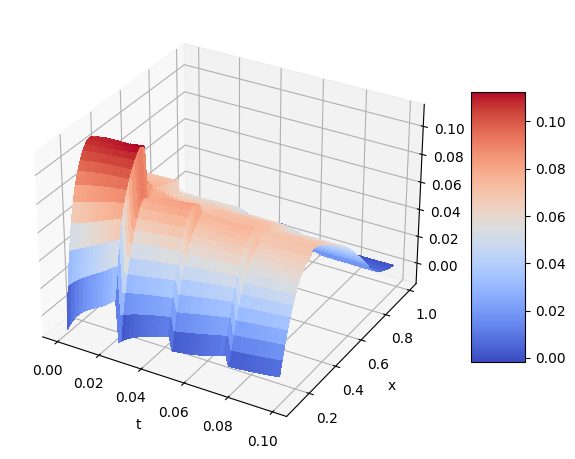

In [ ]:
sol.plot2d(func_num=1)

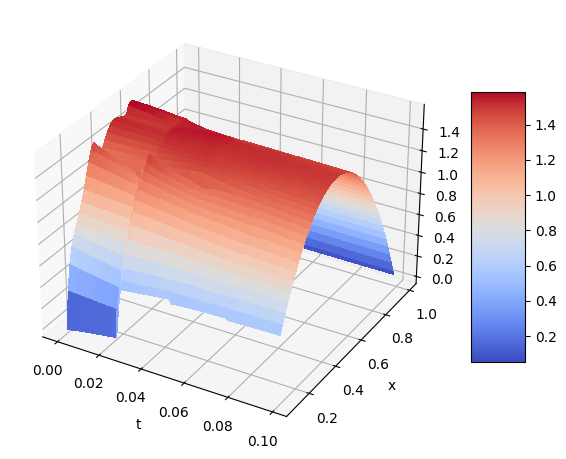

In [ ]:
sol.plot2d(func_num=0)